## Assess FastSpecFit Stellar Mass Estimates

In [67]:
%%html 
<style>table { display: inline-block } </style>

The goal of this notebook is to compare the stellar masses estimated using the following catalogs or techniques:

| Catalog | IMF | H$_{0}$| Photometry | Spectroscopy | SPS Models | SFH Prior | $Z$ Prior | Dust Model | IR Model | AGN? | Nebular Lines | Reference |
| :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- |
| `fastphot` | Chabrier | 100 | *grzW1-W4* | None | FSPS (C3K+MIST) | [1] | (0.1-1.5)$Z_{\odot}$ | $\propto \tau^{-0.7}$ | Draine & Li 2007 | No | Yes | [docs](https://fastspecfit.readthedocs.io/en/latest) |
| `fastspec` | Chabrier | 100 | *grzW1-W4* | All | FSPS (C3K+MIST) | [1] | (0.1-1.5)$Z_{\odot}$ | $\propto \tau^{-0.7}$ | Draine & Li 2007 | No | Yes | [docs](https://fastspecfit.readthedocs.io/en/latest) |
| `Mar/CIGALE-AGN`       | Chabrier | 70 | *grzW1-W4* | None | BC03 (STELIB+Padova?) | $\tau e^{-t/\tau}$+bursts | $Z_{\odot}$ | Calzetti+2000 | Dale+2014 | Yes | Yes | [README](https://data.desi.lbl.gov/doc/releases/edr/vac/cigale/) |
| `Hu/CIGALE`        | Chabrier | 70 | *grzW1-W2* | 10-band synthesized | BC03 (STELIB+Padova?) | $\tau e^{-t/\tau}$ | (0.02-2.5)$Z_{\odot}$ | Charlot & Fall 2000 |Yes |  Draine+2014 | No | [Zou et al. 2023](https://arxiv.org/abs/2312.00300); [README](https://data.desi.lbl.gov/doc/releases/edr/vac/stellar-mass-emline) |
| `Kcorrect`        | Chabrier | 100 | *grzW1-W2* | None | BC03 (STELIB+Padova) | [2] | [2] | [2] | None | No | Yes | [docs](http://kcorrect.org/) |

[1] `FastSpecFit` assumes a non-parametric star-formation history (SFH) with no regularization or enforcement of continuity in the fitted SFH. There are eight templates constructed assuming continuous star formation within the following non-overlapping age bins: `0-10 Myr`; `10-30 Myr`; `30-100 Myr`; `100-330 Myr`; `330 Myr-1.1 Gyr`; `1.1 Gyr-3.6 Gyr`; `3.6-12 Gyr`; `12-14 Gyr`. (The resulting geometric mean ages are `5 Myr`, `25 Myr`, `65 Myr`, `215 Myr`, `715 Myr`, `2.4 Gyr`, `7.8 Gyr`, and `13 Gyr`.) In addition, we consider three stellar metallicities and eight values of dust extinction, resulting in a total of 192 (independent) models.

[2] `Kcorrect` fits a non-negative linear combination of five NMF templates which were trained on early SDSS spectroscopy and photometry. These models have variations in SFH, metallicity, and dust attenuation built into them, but there is no explicit inference of these parameters.

### Input Data

In order to enable rapid testing of the choice of `FastSpecFit` templates and priors, I opted to use just a single healpixel (`7020`) from `sv1/bright`, which contains 230 objects. None of the general conclusions of this analysis change if I use a larger number of objects.

In [68]:
import os
import numpy as np
import fitsio
import corner as cn
from astropy.table import Table, join
from desitarget import geomask

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

In [69]:
import seaborn as sns

sns.set(context='talk', style='whitegrid', font_scale=0.8)
colors = sns.color_palette()

%matplotlib inline

In [70]:
masslim = [6.5, 12]

def get_masstitle(suffix=None):
    masstitle = r'$\log_{10}\, (\mathcal{M}_{*}\, h^{-2}\, /\, \mathcal{M}_{\odot})$'
    if suffix:
        masstitle += f' [{suffix}]'
    return masstitle

##### Cosmology conversion.

In [71]:
little_h = 0.7
hcorr = -2.*np.log10(little_h)
print(f'FastSpecFit and Kcorrect stellar masses are converted to H0=70 km/s/Mpc by adding {hcorr:.5f} dex.')

FastSpecFit and Kcorrect stellar masses are converted to H0=70 km/s/Mpc by adding 0.30980 dex.


### Simple functions to read the various catalogs.

In [124]:
def read_fastspecfit(fastphot=False, templateversion='1.3.0'):
    if fastphot:
        prefix = 'fastphot'
        fits = 'fits'
        ext = 'FASTPHOT'
    else:
        prefix = 'fastspec'
        fits = 'fits'#.gz'
        ext = 'FASTSPEC'
        
    cols = ['SURVEY', 'PROGRAM', 'HEALPIX', 'TARGETID', 'Z', 'LOGMSTAR', 'AGE', 'SFR', 'AV', 'ZZSUN', 'DN4000_MODEL', 'COEFF']
    catfile = f'/pscratch/sd/i/ioannis/fastspecfit/{templateversion}/fuji/catalogs/{prefix}-fuji-sv1-bright.{fits}'
    #catfile = f'/pscratch/sd/i/ioannis/fastspecfit/{templateversion}/fuji/healpix/sv1/bright/70/7020/{prefix}-sv1-bright-7020.{fits}'
    
    fast = Table(fitsio.read(catfile, ext, columns=cols))
    meta = Table(fitsio.read(catfile, 'METADATA'))
    print(f'Read {len(fast):,d} objects from {catfile}')
    
    # correct for cosmology
    fast['LOGMSTAR'] = fast['LOGMSTAR'] + hcorr
    
    fast = join(fast, meta)
    return fast

In [137]:
def read_mar(fast):
    catfile = '/global/cfs/cdirs/desi/public/edr/vac/edr/cigale/fuji/v1.1/FujiPhysProp_v1.1.fits'
    cols = ['TARGETID', 'LOGM', 'LOGSFR']#, 'FLAG_MASSPDF']
    cat = Table(fitsio.read(catfile, columns=cols))
    print(f'Read {len(cat):,d} objects from {catfile}')
    
    # match
    indx = geomask.match_to(cat['TARGETID'], fast['TARGETID'])
    print(f'Matched to {len(indx):,d} objects in the input fastspecfit catalog.')
    cat = cat[indx]
    assert(np.all(cat['TARGETID'] == fast['TARGETID']))
    
    cat['MSTAR'] = cat['LOGM']
    
    return cat

In [163]:
def read_hu(fast):
    catfile = '/global/cfs/cdirs/desi/public/edr/vac/edr/stellar-mass-emline/v1.0/edr_galaxy_stellarmass_lineinfo_v1.0.fits'
    cols = ['TARGETID', 'SED_MASS', 'SED_AV', 'SED_AGE', 'SED_TAU', 'SED_SFR']
    cat = Table(fitsio.read(catfile, columns=cols))
    print(f'Read {len(cat):,d} objects from {catfile}')
    
    _, uindx = np.unique(cat['TARGETID'], return_index=True)
    cat = cat[uindx]
    print(f'Trimmed to {len(cat):,d} unique objects.')

    # match
    indx_fast, indx = geomask.match(fast['TARGETID'], cat['TARGETID'])
    print(f'Matched to {len(indx):,d} objects in the input fastspecfit catalog.')
    cat = cat[indx]
    assert(np.all(cat['TARGETID'] == fast['TARGETID'][indx_fast]))
    
    cat['MSTAR'] = np.log10(cat['SED_MASS'])
    #cat['AGE'] = 
    
    return cat, indx_fast

In [164]:
def read_prospector(priors='delayedtau'):
    catfile = f'/global/cfs/cdirs/desi/users/ioannis/fastspecfit/fastpaper1/data/prospector/{priors}.fits'
    cat = Table(fitsio.read(catfile))
    print(f'Read {len(cat):,d} objects from {catfile}')
    
    cat['MSTAR'] = np.zeros(len(cat), 'f4')
    
    if priors == 'delayedtau':
        I = cat['MASS'] > 0
        cat['MSTAR'][I] = np.log10(cat['MASS'][I] * cat['MREMAIN'][I]) + hcorr
    elif priors == 'continuitysfh':
        I = cat['LOGMASS'] > 0
        cat['MSTAR'][I] = cat['LOGMASS'][I] + np.log10(cat['MREMAIN'][I]) + hcorr
    
    return cat

In [165]:
fastphot = read_fastspecfit(fastphot=True, templateversion='1.3.1')
#fastphot

Read 230 objects from /pscratch/sd/i/ioannis/fastspecfit/1.3.1/fuji/catalogs/fastphot-fuji-sv1-bright.fits


In [167]:
hu, indx_fast = read_hu(fastphot)
#hu

Read 1,223,269 objects from /global/cfs/cdirs/desi/public/edr/vac/edr/stellar-mass-emline/v1.0/edr_galaxy_stellarmass_lineinfo_v1.0.fits
Trimmed to 1,122,660 unique objects.
Matched to 224 objects in the input fastspecfit catalog.


In [160]:
fastspec = read_fastspecfit(fastphot=False, templateversion='1.2.1')
#fastspec

Read 230 objects from /pscratch/sd/i/ioannis/fastspecfit/1.2.1/fuji/catalogs/fastspec-fuji-sv1-bright.fits


In [146]:
mar = read_mar(fastphot)
#mar

Read 1,286,124 objects from /global/cfs/cdirs/desi/public/edr/vac/edr/cigale/fuji/v1.1/FujiPhysProp_v1.1.fits
Matched to 230 objects in the input fastspecfit catalog.


In [127]:
delayed = read_prospector(priors='delayedtau')
continuity = read_prospector(priors='continuitysfh')

Read 230 objects from /global/cfs/cdirs/desi/users/ioannis/fastspecfit/fastpaper1/data/prospector/delayedtau.fits
Read 230 objects from /global/cfs/cdirs/desi/users/ioannis/fastspecfit/fastpaper1/data/prospector/continuitysfh.fits


In [184]:
bb = fastphot[delayed['MSTAR'] > 0]
bb[np.argmin(bb['AGE'])]

TARGETID,SURVEY,PROGRAM,HEALPIX,Z,COEFF,AV,AGE,ZZSUN,LOGMSTAR,SFR,DN4000_MODEL,TILEID_LIST,RA,DEC,COADD_FIBERSTATUS,CMX_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV1_SCND_TARGET,SV2_SCND_TARGET,SV3_SCND_TARGET,ZWARN,DELTACHI2,SPECTYPE,Z_RR,TSNR2_BGS,TSNR2_LRG,TSNR2_ELG,TSNR2_QSO,TSNR2_LYA,PHOTSYS,LS_ID,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,EBV,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4
int64,str3,str6,int32,float64,float32[40],float32,float32,float32,float32,float32,float32,str5,float64,float64,int32,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,str6,float64,float32,float32,float32,float32,float32,str1,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
39633321180792960,sv1,bright,7020,1.565187849091144,0.0 .. 0.0,0.11521167,0.015002715,0.0,9.978534,2.9994563e-08,1.0535936,80613,108.19709560678338,54.93262353724648,0,0,0,0,0,0,1152921504606846976,257,0,0,0,0,0,0,0,0,0,0,0,65.93256568908691,GALAXY,1.565187849091144,23814.318,230.60196,333.17218,72.1257,107.00506,N,9907738716473472,1.5187209,3.1880937,4.728136,1.9207442,3.7295005,5.154952,7.283389,14.142124,19.547382,5.164981,1.6740996,66.71926,-2207.8918,104.786,56.210438,15.825719,1.9660358,0.52634764,0.0008050558,1.2337553e-05,0.0782624,0.790694,0.8548313,0.9172028,0.9868244,0.9918878,0.9982643,0.9993443


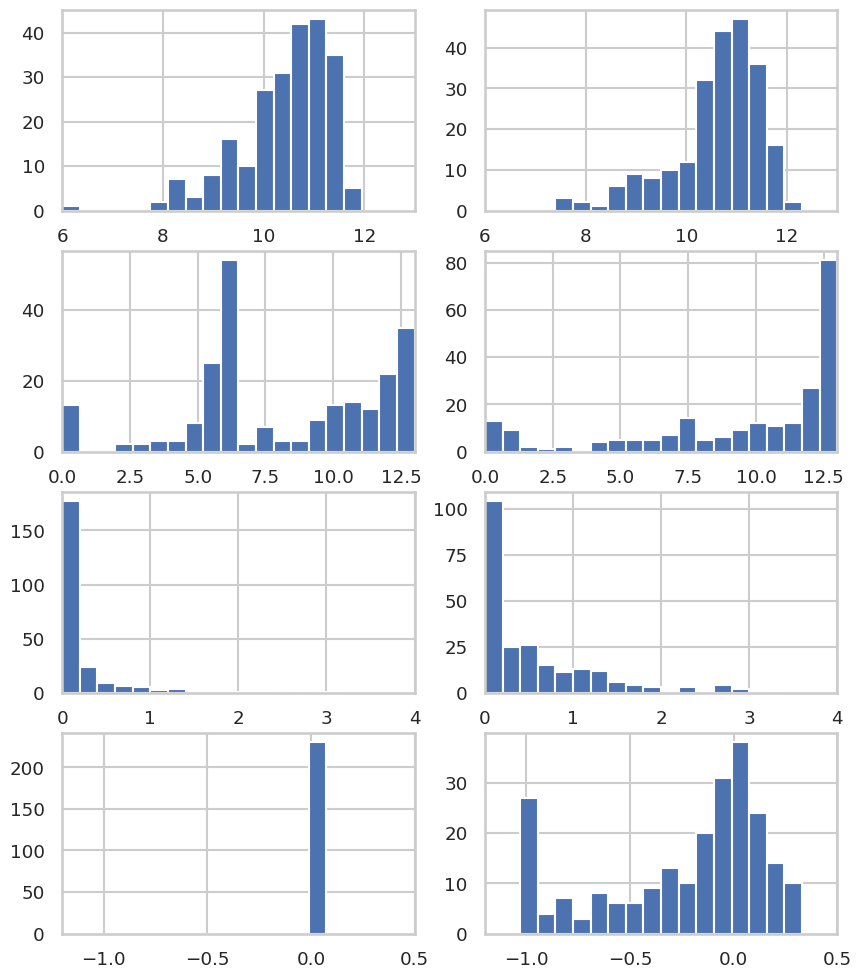

In [176]:
fig, ax = plt.subplots(4, 2, figsize=(10, 12))
for ii, (prop, lim) in enumerate(zip(['LOGMSTAR', 'AGE', 'AV', 'ZZSUN'],
                                     [[6, 13], [0, 13], [0, 4], [-1.2, 0.5]])):
    ax[ii, 0].hist(fastphot[prop], range=lim, bins=20);
    ax[ii, 1].hist(fastspec[prop], range=lim, bins=20);
    for xx in ax[ii, :]:
        xx.set_xlim(lim)

0.10430106644111348
0.2398661075263142


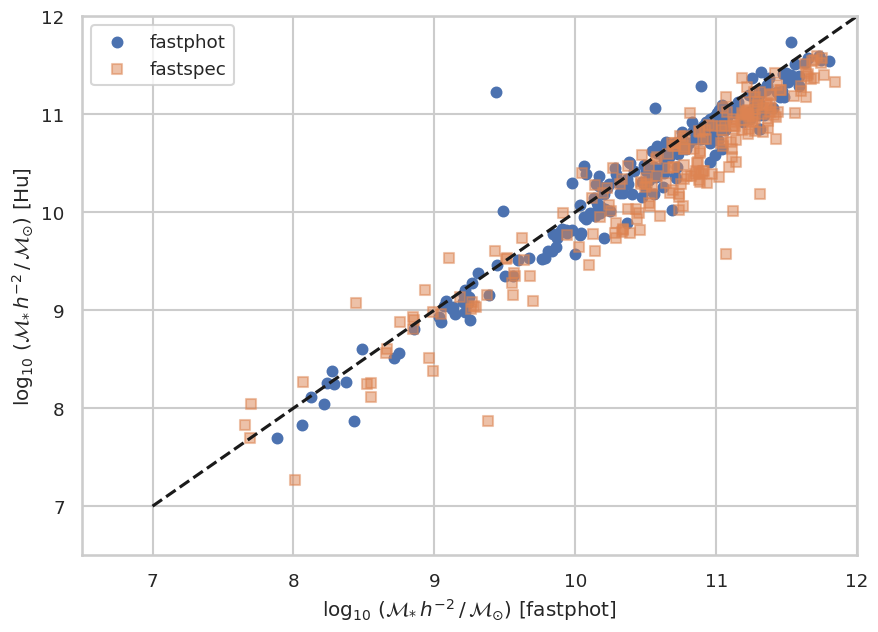

In [170]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(fastphot['LOGMSTAR'][indx_fast], hu['MSTAR'], s=50, 
           marker='o', alpha=1., color=colors[0], label='fastphot')
ax.scatter(fastspec['LOGMSTAR'][indx_fast], hu['MSTAR'], s=50, 
           marker='s', alpha=0.5, color=colors[1], label='fastspec')
print(np.median(fastphot['LOGMSTAR'][indx_fast]-hu['MSTAR']))
print(np.median(fastspec['LOGMSTAR'][indx_fast]-hu['MSTAR']))
ax.plot([7, 12], [7, 12], ls='--', color='k')
ax.set_xlim(masslim)
ax.set_ylim(masslim)
ax.set_xlabel(get_masstitle(suffix='fastphot'));
ax.set_ylabel(get_masstitle(suffix='Hu'));
ax.legend(loc='upper left');

0.26224491080982926
0.44535666270431395


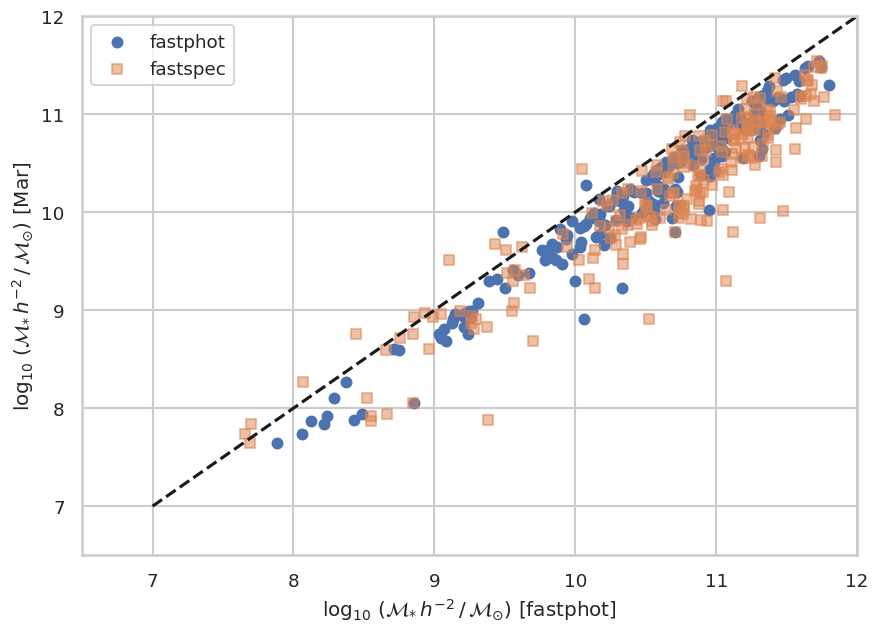

In [171]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(fastphot['LOGMSTAR'], mar['MSTAR'], s=50, 
           marker='o', alpha=1., color=colors[0], label='fastphot')
ax.scatter(fastspec['LOGMSTAR'], mar['MSTAR'], s=50, 
           marker='s', alpha=0.5, color=colors[1], label='fastspec')
print(np.median(fastphot['LOGMSTAR']-mar['MSTAR']))
print(np.median(fastspec['LOGMSTAR']-mar['MSTAR']))
ax.plot([7, 12], [7, 12], ls='--', color='k')
ax.set_xlim(masslim)
ax.set_ylim(masslim)
ax.set_xlabel(get_masstitle(suffix='fastphot'));
ax.set_ylabel(get_masstitle(suffix='Mar'));
ax.legend(loc='upper left');

0.17183018
0.016886234


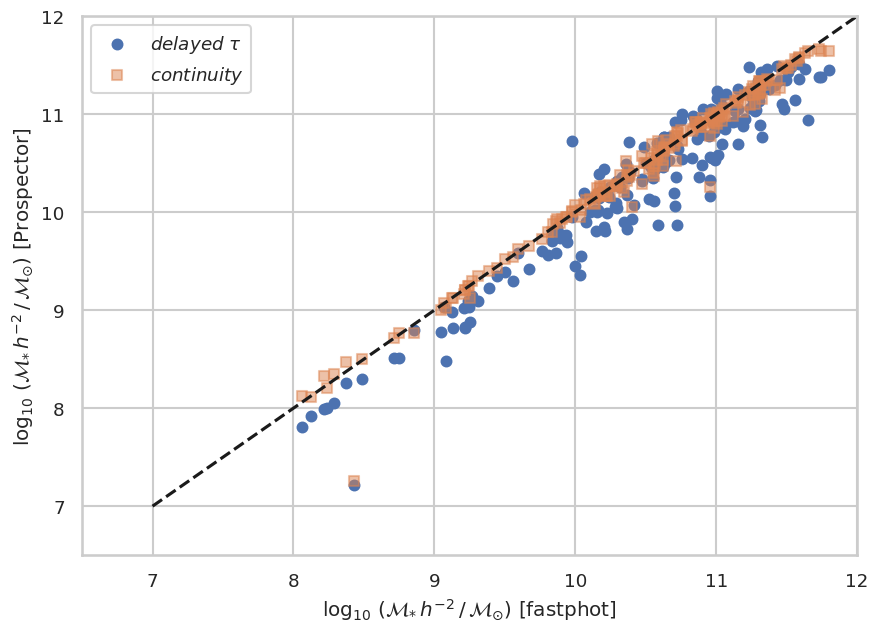

In [142]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(fastphot['LOGMSTAR'], delayed['MSTAR'], s=50, 
           marker='o', alpha=1., color=colors[0], label=r'$delayed\ \tau$')
ax.scatter(fastphot['LOGMSTAR'], continuity['MSTAR'], s=50, 
           marker='s', alpha=0.5, color=colors[1], label=r'$continuity$')
print(np.median(fastphot['LOGMSTAR']-delayed['MSTAR']))
print(np.median(fastphot['LOGMSTAR']-continuity['MSTAR']))
ax.plot([7, 12], [7, 12], ls='--', color='k')
ax.set_xlim(masslim)
ax.set_ylim(masslim)
ax.set_xlabel(get_masstitle(suffix='fastphot'));
ax.set_ylabel(get_masstitle(suffix='Prospector'));
ax.legend(loc='upper left');

0.33592463
0.20551395


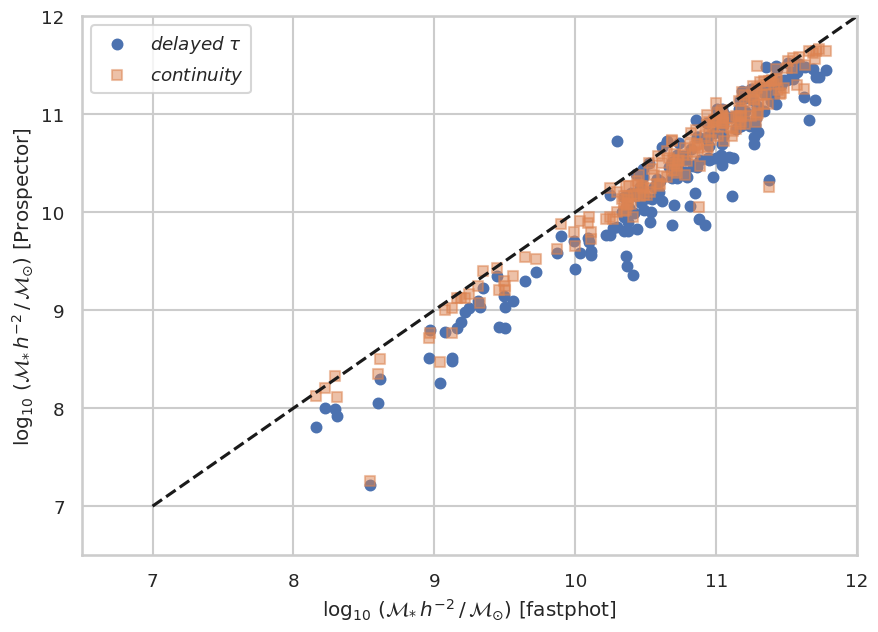

In [108]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(fastphot['LOGMSTAR'], delayed['MSTAR'], s=50, 
           marker='o', alpha=1., color=colors[0], label=r'$delayed\ \tau$')
ax.scatter(fastphot['LOGMSTAR'], continuity['MSTAR'], s=50, 
           marker='s', alpha=0.5, color=colors[1], label=r'$continuity$')
print(np.median(fastphot['LOGMSTAR']-delayed['MSTAR']))
print(np.median(fastphot['LOGMSTAR']-continuity['MSTAR']))
ax.plot([7, 12], [7, 12], ls='--', color='k')
ax.set_xlim(masslim)
ax.set_ylim(masslim)
ax.set_xlabel(get_masstitle(suffix='fastphot'));
ax.set_ylabel(get_masstitle(suffix='Prospector'));
ax.legend(loc='upper left');

0.35348558
0.21863031


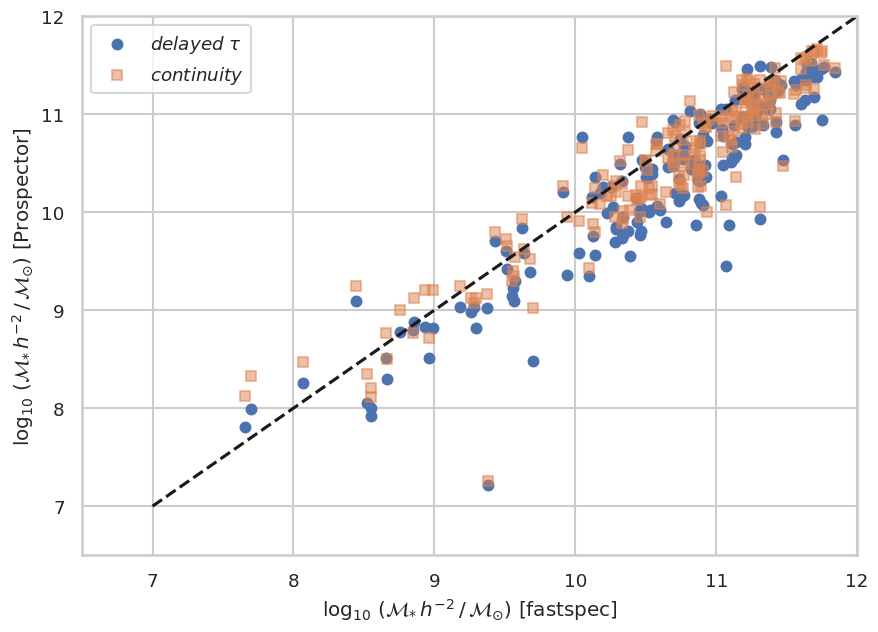

In [110]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(fastspec['LOGMSTAR'], delayed['MSTAR'], s=50, 
           marker='o', alpha=1., color=colors[0], label=r'$delayed\ \tau$')
ax.scatter(fastspec['LOGMSTAR'], continuity['MSTAR'], s=50, 
           marker='s', alpha=0.5, color=colors[1], label=r'$continuity$')
print(np.median(fastspec['LOGMSTAR']-delayed['MSTAR']))
print(np.median(fastspec['LOGMSTAR']-continuity['MSTAR']))
ax.plot([7, 12], [7, 12], ls='--', color='k')
ax.set_xlim(masslim)
ax.set_ylim(masslim)
ax.set_xlabel(get_masstitle(suffix='fastspec'));
ax.set_ylabel(get_masstitle(suffix='Prospector'));
ax.legend(loc='upper left');

In [7]:
v1file = '/pscratch/sd/i/ioannis/fastspecfit/1.2.0/fuji/catalogs/fastphot-fuji-sv1-bright.fits'
v2file = '/pscratch/sd/i/ioannis/fastspecfit/1.2.1/fuji/catalogs/fastspec-fuji-sv1-bright.fits'
cols = ['SURVEY', 'PROGRAM', 'HEALPIX', 'TARGETID', 'Z', 'LOGMSTAR', 'AGE', 'SFR', 'AV', 'ZZSUN', 'DN4000_MODEL']
fast1 = Table(fitsio.read(v1file, 'FASTPHOT', columns=cols))
meta1 = Table(fitsio.read(v1file, 'METADATA'))
fast2 = Table(fitsio.read(v2file, 'FASTSPEC', columns=cols))

print(np.log10(little_h**(-2)))
fast1['LOGMSTAR'] = fast1['LOGMSTAR'] + np.log10(little_h**(-2))
fast2['LOGMSTAR'] = fast2['LOGMSTAR'] + np.log10(little_h**(-2))

#fast1
#meta1

0.3098039199714864


-0.048671246


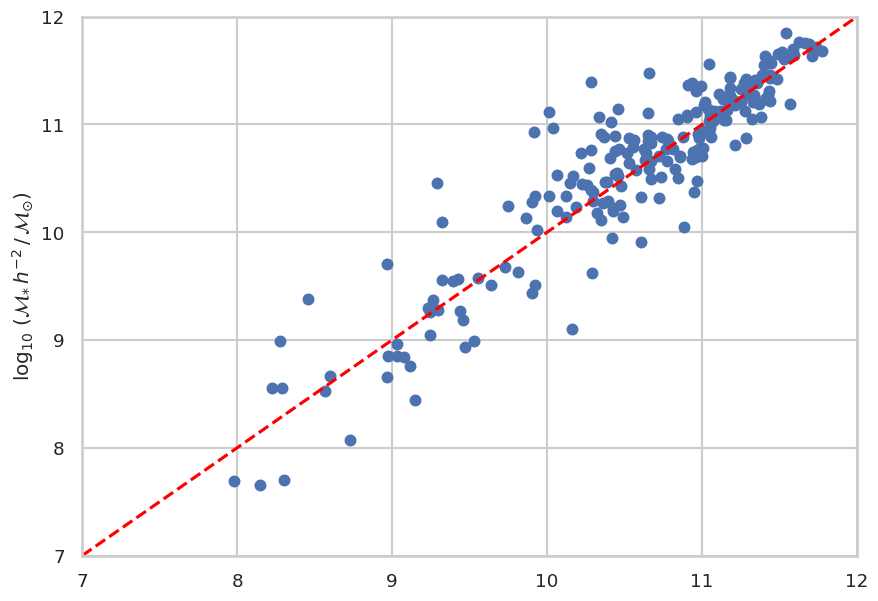

In [8]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(fast1['LOGMSTAR'], fast2['LOGMSTAR'], s=50, alpha=1, color=colors[0])
print(np.median(fast1['LOGMSTAR']-fast2['LOGMSTAR']))
ax.plot([7, 12], [7, 12], ls='--', color='red')
ax.set_xlim(7, 12)
ax.set_ylim(7, 12)
ax.set_ylabel(r'$\log_{10}\, (\mathcal{M}_{*}\, h^{-2}\, /\, \mathcal{M}_{\odot})$');

In [24]:
fast2[fast2['TARGETID'] == 39633331532335268]

TARGETID,SURVEY,PROGRAM,HEALPIX,Z,AV,AGE,ZZSUN,LOGMSTAR,SFR,DN4000_MODEL
int64,str3,str6,int32,float64,float32,float32,float32,float32,float32,float32
39633331532335268,sv1,bright,7020,0.3257941850812696,1.4391072,11.902367,-0.5116837,11.045636,0.0,1.3167465


In [11]:
out2 = join(fast2[indx_fast_mar]['TARGETID', 'LOGMSTAR'], mar, keys='TARGETID')
out2 = join(out2, meta1['TARGETID', 'Z'][indx_fast_mar], keys='TARGETID')
print(np.median(out2['LOGMSTAR'] - out2['LOGM']))
out2

0.44535666270431395


TARGETID,LOGMSTAR,LOGM,LOGSFR,FLAG_MASSPDF,Z
int64,float32,float64,float64,float64,float64
39633317682745114,11.212696,10.97509612237593,-9.408971931818654,inf,0.44987075057466086
39633317686935607,11.113844,10.588716383314889,0.42021891198752115,inf,0.44864095227873557
39633317686935908,11.142892,0.0,0.0,inf,0.44547771134835973
39633317686936497,10.88304,10.636078437176652,-5.175757768599357,inf,0.2153526873379466
39633317686937084,10.428648,9.92133648188179,0.17267542314720208,inf,0.24264006804722324
39633317686937667,11.221164,10.862970185357339,-6.088190543400598,inf,0.4410597187811772
39633317686938181,10.894837,9.918851180809611,-0.3309862308757628,inf,0.24323289154941638
39633317686938213,11.694786,11.484039051572099,-9.829824582865548,inf,0.4420494305541205
39633317686938944,11.234974,10.894715628544832,-11.826236863456337,inf,0.3744473158171297


In [12]:
out1 = join(fast1[indx_fast_mar]['TARGETID', 'LOGMSTAR'], mar['TARGETID', 'LOGM', 'LOGSFR'], keys='TARGETID')
out1 = join(out1, meta1['TARGETID', 'Z', 'FLUX_G', 'FLUX_R', 'FLUX_Z'][indx_fast_mar], keys='TARGETID')
print(np.median(out1['LOGMSTAR'] - out1['LOGM']))
out1[:5]

0.4105026184050331


TARGETID,LOGMSTAR,LOGM,LOGSFR,Z,FLUX_G,FLUX_R,FLUX_Z
int64,float32,float64,float64,float64,float32,float32,float32
39633317682745114,11.019881,10.97509612237593,-9.408971931818654,0.44987075057466086,1.3385121,6.834274,17.12872
39633317686935607,11.05305,10.588716383314889,0.42021891198752115,0.44864095227873557,2.0764663,6.4258046,12.681264
39633317686935908,10.455242,0.0,0.0,0.44547771134835973,5.4521036,13.629732,25.922386
39633317686936497,11.055836,10.636078437176652,-5.175757768599357,0.2153526873379466,10.879126,33.93054,65.95225
39633317686937084,10.476527,9.92133648188179,0.17267542314720208,0.24264006804722324,5.1353507,10.396055,16.784657


(7.0, 12.0)

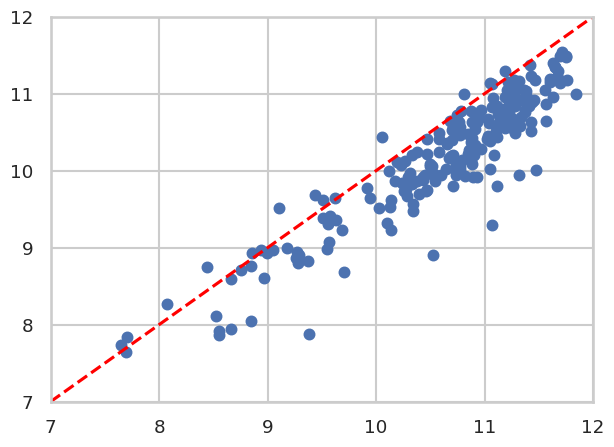

In [13]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(out2['LOGMSTAR'], out2['LOGM'], s=50, alpha=1, color=colors[0])
#ax.scatter(out2['LOGMSTAR'], mar['LOGM'], s=50, color='red')
ax.plot([7, 12], [7, 12], ls='--', color='red')
ax.set_xlim(7, 12)
ax.set_ylim(7, 12)

(-1.0, 2.0)

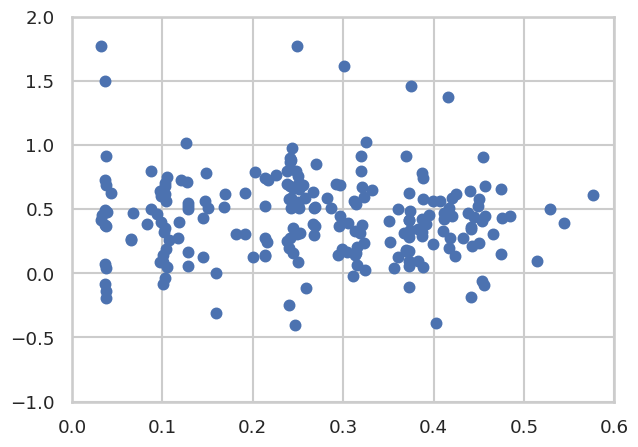

In [14]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(out2['Z'], out2['LOGMSTAR']-out2['LOGM'], s=50, alpha=1, color=colors[0])
#ax.plot([7, 12], [7, 12], ls='--', color='red')
ax.set_xlim(0, 0.6)
ax.set_ylim(-1, 2)

# Zou

In [15]:
zoufile = '/global/cfs/cdirs/desi/public/edr/vac/edr/stellar-mass-emline/v1.0/edr_galaxy_stellarmass_lineinfo_v1.0.fits'
cols = ['TARGETID', 'SED_MASS', 'SED_AV', 'SED_AGE', 'SED_TAU', 'SED_SFR']
zou = Table(fitsio.read(zoufile, columns=cols))
_, uindx = np.unique(zou['TARGETID'], return_index=True)
zou = zou[uindx]
indx_fast_zou, indx_zou = geomask.match(fast1['TARGETID'], zou['TARGETID'])
zou = zou[indx_zou]
#print(fitsio.FITS(zoufile)[1].get_colnames())

In [16]:
out2_zou = join(fast2[indx_fast_zou]['TARGETID', 'LOGMSTAR', 'AV', 'AGE', 'DN4000_MODEL'], zou['TARGETID', 'SED_MASS', 'SED_SFR', 'SED_AV', 'SED_AGE'], keys='TARGETID')
out2_zou = join(out2_zou, meta1['TARGETID', 'FLUX_G', 'FLUX_R', 'FLUX_Z'][indx_fast_zou], keys='TARGETID')
out2_zou['SED_MASS'] = np.log10(out2_zou['SED_MASS'])
out2_zou['SED_AGE'] = (out2_zou['SED_AGE'] / 1e3).astype('f4')
print(np.median(out2_zou['LOGMSTAR'] - out2_zou['SED_MASS']))
out2_zou#[:5]

0.2398661075263142


TARGETID,LOGMSTAR,AV,AGE,DN4000_MODEL,SED_MASS,SED_SFR,SED_AV,SED_AGE,FLUX_G,FLUX_R,FLUX_Z
int64,float32,float32,float32,float32,float64,float64,float64,float32,float32,float32,float32
39633317682745114,11.212696,0.049384616,12.533385,1.7437662,11.033685658752683,0.10530446801452037,0.5835141404701919,5.031457,1.3385121,6.834274,17.12872
39633317686935607,11.113844,0.6117393,11.713184,1.297732,10.6466444892782,11.951556994461493,0.887863987069777,6.107824,2.0764663,6.4258046,12.681264
39633317686935908,11.142892,0.0,12.992876,1.3146492,10.50971284647374,10.127518413078404,0.4570102787243159,3.6245458,5.4521036,13.629732,25.922386
39633317686936497,10.88304,0.0027511984,10.064255,1.817885,10.813382273429196,0.0438007807056282,0.40440303994177274,6.888781,10.879126,33.93054,65.95225
39633317686937084,10.428648,0.49081677,10.920872,1.3281621,10.030621166756662,2.714106447280182,0.7860204791152756,5.648121,5.1353507,10.396055,16.784657
39633317686937667,11.221164,0.10591549,12.992183,1.8593154,11.012213717343329,0.11241460116511534,0.5873190940378765,5.304868,1.4581466,6.8433504,17.52966
39633317686938181,10.894837,1.0036018,12.966081,1.2108295,10.391080801301712,0.23956166874452878,0.2473612698828011,5.7530904,8.905003,19.107487,30.817123
39633317686938213,11.694786,0.37714955,11.752404,1.9418832,11.556760477443635,0.22272655580663564,0.6162743226274995,5.4821444,3.262561,18.79854,49.8169
39633317686938944,11.234974,0.42747316,12.996725,1.7570977,10.974615046915154,0.028946950560815483,0.4754550389444264,6.0948286,1.8766819,9.159317,22.261404


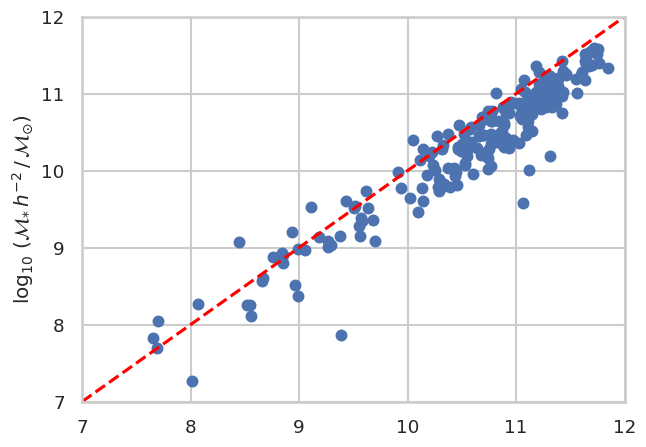

In [17]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(out2_zou['LOGMSTAR'], out2_zou['SED_MASS'], s=50, alpha=1, color=colors[0])
#$ax.scatter(fast2['LOGMSTAR'][indx_fast][I], np.log10(cat['SED_MASS'][I]), s=50, color='red')
ax.plot([7, 12], [7, 12], ls='--', color='red')
ax.set_xlim(7, 12)
ax.set_ylim(7, 12)
ax.set_ylabel(r'$\log_{10}\, (\mathcal{M}_{*}\, h^{-2}\, /\, \mathcal{M}_{\odot})$');

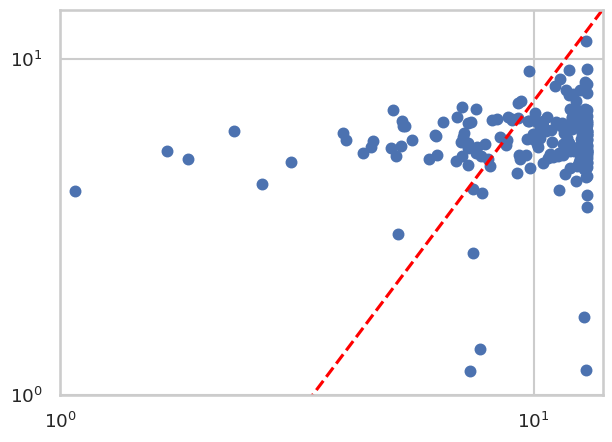

In [18]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(out2_zou['AGE'], out2_zou['SED_AGE'], s=50, alpha=1, color=colors[0])
ax.plot([1, 14], [0.1, 14], ls='--', color='red')
ax.set_xlim(1, 14)
ax.set_ylim(1, 14)
ax.set_xscale('log')
ax.set_yscale('log')

(0.8, 2.4)

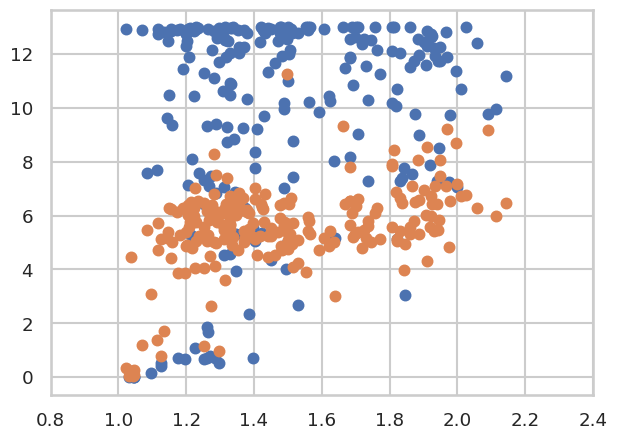

In [21]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(out2_zou['DN4000_MODEL'], out2_zou['AGE'], s=50, alpha=1, color=colors[0])
ax.scatter(out2_zou['DN4000_MODEL'], out2_zou['SED_AGE'], s=50, alpha=1, color=colors[1])
#ax.plot([1, 14], [0.1, 14], ls='--', color='red')
ax.set_xlim(0.8, 2.4)
#ax.set_ylim(1, 14)
#ax.set_xscale('log')
#ax.set_yscale('log')

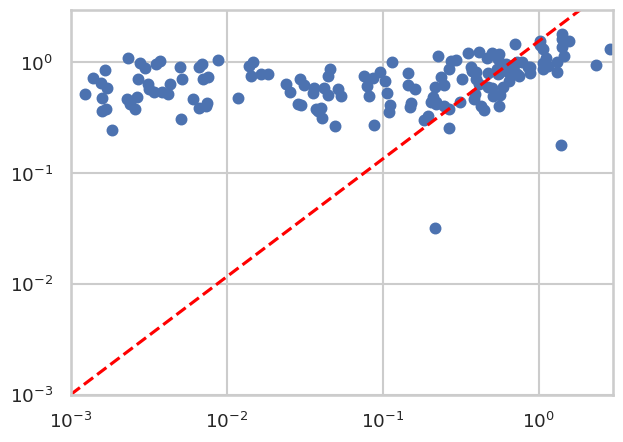

In [234]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(out2_zou['AV'], out2_zou['SED_AV'], s=50, alpha=1, color=colors[0])
ax.plot([0.001, 3], [0.001, 5], ls='--', color='red')
ax.set_xlim(0.001, 3)
ax.set_ylim(0.001, 3)
ax.set_xscale('log')
ax.set_yscale('log')

In [235]:
I = ((fast2['LOGMSTAR'][indx_fast]-np.log10(cat['SED_MASS'])) > 0.3) * (np.log10(cat['SED_MASS']) > 10.8)
out = Table()
out['TARGETID'] = cat[I]['TARGETID']
out['SURVEY'] = meta1['SURVEY'][indx_fast][I]
out['PROGRAM'] = meta1['PROGRAM'][indx_fast][I]
out['HEALPIX'] = meta1['HEALPIX'][indx_fast][I]
out['MSTAR_ZOU'] = np.log10(cat[I]['SED_MASS'])
out['MSTAR_FAST'] = fast2['LOGMSTAR'][indx_fast][I]
out['AGE_FAST'] = fast2['AGE'][indx_fast][I]
out

TARGETID,SURVEY,PROGRAM,HEALPIX,MSTAR_ZOU,MSTAR_FAST,AGE_FAST
int64,str3,str6,int32,float64,float32,float32
39633321180791214,sv1,bright,7020,10.98855131382357,11.343637,12.922037
39633321180794014,sv1,bright,7020,10.822023380174816,11.179266,12.965622
39633321180794849,sv1,bright,7020,10.991237337537063,11.368619,12.820518
39633321184985740,sv1,bright,7020,10.80069336072851,11.15354,12.8789425
39633324653678364,sv1,bright,7020,10.967811744830245,11.282252,12.56014
39633324657868925,sv1,bright,7020,10.928062296296574,11.303288,10.874742
39633328101393681,sv1,bright,7020,11.00071459571256,11.32873,12.658292
39633328101393864,sv1,bright,7020,10.850766388847978,11.2785,12.939577
39633331532334546,sv1,bright,7020,10.84784376213476,11.404812,12.904028


(0.1, 5)

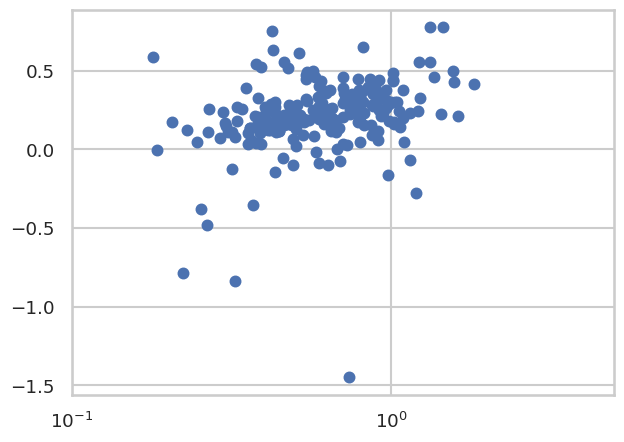

In [240]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(out2_zou['SED_AV'], out2_zou['LOGMSTAR']-out2_zou['SED_MASS'], s=50, alpha=1, color=colors[0])
ax.set_xscale('log')
ax.set_xlim(0.1, 5)
#ax.scatter(np.log10(cat['SED_MASS']), fast1['LOGMSTAR'][indx_fast]-np.log10(cat['SED_MASS']), s=50, alpha=1, color=colors[0])
#ax.plot([7, 12], [7, 12], ls='--', color='red')
#ax.set_xlim(7, 12)
#ax.set_ylim(7, 12)

In [ ]:
stop

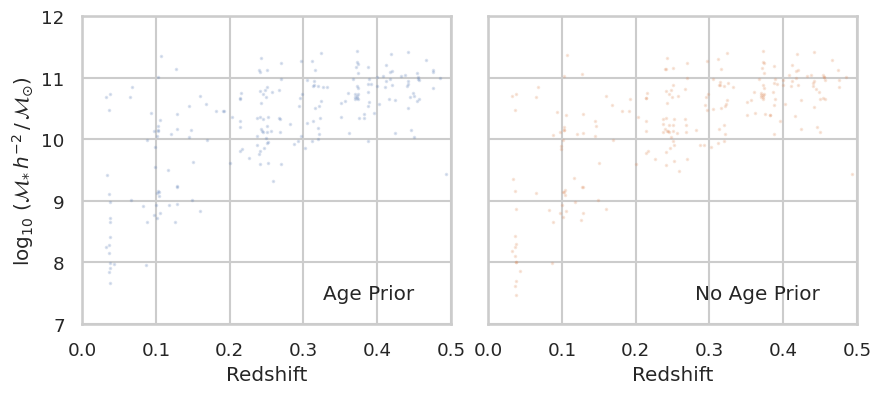

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
ax1.scatter(fast1['Z'], fast1['LOGMSTAR'], s=1, alpha=0.2, color=colors[0])
ax2.scatter(fast2['Z'], fast2['LOGMSTAR'], s=1, alpha=0.2, color=colors[1])
for xx, label in zip((ax1, ax2), ('Age Prior', 'No Age Prior')):
    xx.set_xlim(0, 0.5)
    xx.set_ylim(7, 12)
    xx.set_xlabel('Redshift')
    xx.text(0.9, 0.1, label, ha='right', va='center', 
            transform=xx.transAxes)#, fontsize=10)
ax1.set_ylabel(r'$\log_{10}\, (\mathcal{M}_{*}\, h^{-2}\, /\, \mathcal{M}_{\odot})$');
fig.subplots_adjust(wspace=0.1)

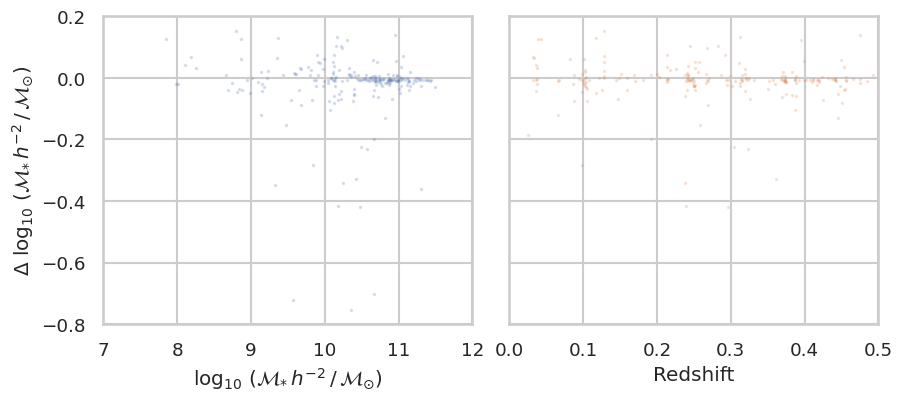

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
ax1.scatter(fast2['LOGMSTAR'], fast1['LOGMSTAR']-fast2['LOGMSTAR'], s=1, alpha=0.2, color=colors[0])
ax2.scatter(fast2['Z'], fast1['LOGMSTAR']-fast2['LOGMSTAR'], s=1, alpha=0.2, color=colors[1])
for xx, label in zip((ax1, ax2), ('Age Prior', 'No Age Prior')):
    xx.set_ylim(-0.8, 0.2)
ax1.set_xlim(7, 12)
ax2.set_xlim(0, 0.5)
ax1.set_xlabel(r'$\log_{10}\, (\mathcal{M}_{*}\, h^{-2}\, /\, \mathcal{M}_{\odot})$');
ax2.set_xlabel('Redshift')
ax1.set_ylabel(r'$\Delta\ \log_{10}\, (\mathcal{M}_{*}\, h^{-2}\, /\, \mathcal{M}_{\odot})$');
fig.subplots_adjust(wspace=0.1)

fast1 minus PROVABGS = nan +/- nan (nan)
fast2 minus PROVABGS = nan +/- nan (nan)


/global/common/software/desi/perlmutter/desiconda/20230111-2.1.0/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/global/common/software/desi/perlmutter/desiconda/20230111-2.1.0/conda/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/global/common/software/desi/perlmutter/desiconda/20230111-2.1.0/conda/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/common/software/desi/perlmutter/desiconda/20230111-2.1.0/conda/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/global/common/software/desi/perlmutter/desiconda/2023

ValueError: operands could not be broadcast together with shapes (230,) (0,) 

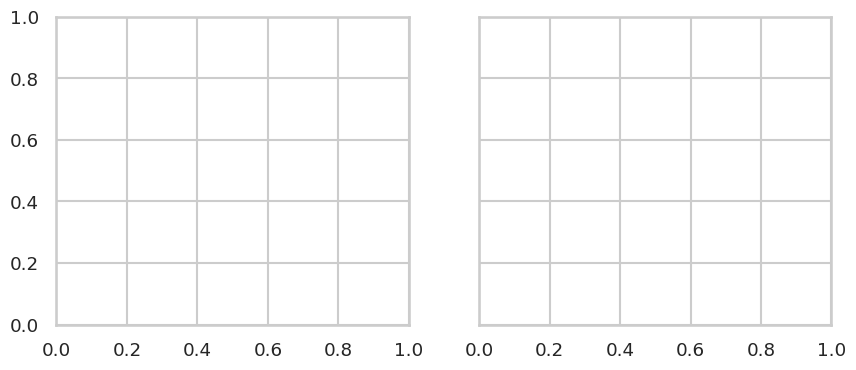

In [9]:
I = (cat['LOGMSTAR_PROVABGS'] > 7) * (cat['LOGMSTAR_PROVABGS'] < 13)
print('fast1 minus PROVABGS = {:.3f} +/- {:.3f} ({:.3f})'.format(
    np.mean(fast1['LOGMSTAR'][I]-cat['LOGMSTAR_PROVABGS'][I]),
    np.std(fast1['LOGMSTAR'][I]-cat['LOGMSTAR_PROVABGS'][I]),
    np.median(fast1['LOGMSTAR'][I]-cat['LOGMSTAR_PROVABGS'][I])))    
print('fast2 minus PROVABGS = {:.3f} +/- {:.3f} ({:.3f})'.format(
    np.mean(fast2['LOGMSTAR'][I]-cat['LOGMSTAR_PROVABGS'][I]),
    np.std(fast2['LOGMSTAR'][I]-cat['LOGMSTAR_PROVABGS'][I]),
    np.median(fast2['LOGMSTAR'][I]-cat['LOGMSTAR_PROVABGS'][I])))    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
ax1.scatter(fast1['LOGMSTAR'], fast1['LOGMSTAR']-cat['LOGMSTAR_PROVABGS'], s=1, alpha=0.2, color=colors[0])
ax2.scatter(fast2['LOGMSTAR'], fast2['LOGMSTAR']-cat['LOGMSTAR_PROVABGS'], s=1, alpha=0.2, color=colors[1])
for xx, label in zip((ax1, ax2), ('Age Prior vs PROVABGS', 'No Age Prior vs PROVABGS')):
    xx.set_ylim(-2, 2)
    xx.text(0.04, 0.95, label, ha='left', va='top', 
            transform=xx.transAxes)#, fontsize=10)
    xx.axhline(y=0, color='k', lw=1)
ax1.set_xlim(7, 12)
ax2.set_xlim(7, 12)
ax1.set_xlabel(r'$\log_{10}\, (\mathcal{M}_{*}\, h^{-2}\, /\, \mathcal{M}_{\odot})$');
ax2.set_xlabel('Redshift')
ax1.set_ylabel(r'$\Delta\ \log_{10}\, (\mathcal{M}_{*}\, h^{-2}\, /\, \mathcal{M}_{\odot})$');
fig.subplots_adjust(wspace=0.1)

fast1 minus cigale = -0.270 +/- 0.320 (-0.329)
fast2 minus cigale = -0.066 +/- 0.323 (-0.134)


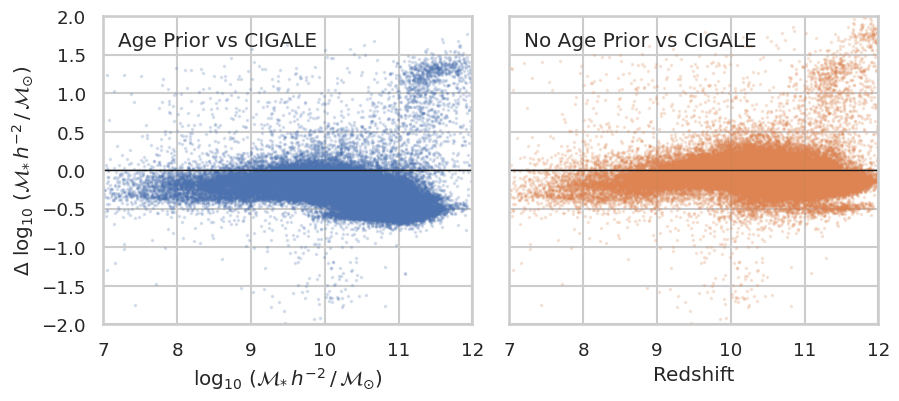

In [118]:
print('fast1 minus cigale = {:.3f} +/- {:.3f} ({:.3f})'.format(
    np.mean(fast1['LOGMSTAR']-cat['LOGMSTAR_CIGALE']),
    np.std(fast1['LOGMSTAR']-cat['LOGMSTAR_CIGALE']),
    np.median(fast1['LOGMSTAR']-cat['LOGMSTAR_CIGALE'])))    
print('fast2 minus cigale = {:.3f} +/- {:.3f} ({:.3f})'.format(
    np.mean(fast2['LOGMSTAR']-cat['LOGMSTAR_CIGALE']),
    np.std(fast2['LOGMSTAR']-cat['LOGMSTAR_CIGALE']),
    np.median(fast2['LOGMSTAR']-cat['LOGMSTAR_CIGALE'])))    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
ax1.scatter(fast1['LOGMSTAR'], fast1['LOGMSTAR']-cat['LOGMSTAR_CIGALE'], s=1, alpha=0.2, color=colors[0])
ax2.scatter(fast2['LOGMSTAR'], fast2['LOGMSTAR']-cat['LOGMSTAR_CIGALE'], s=1, alpha=0.2, color=colors[1])
for xx, label in zip((ax1, ax2), ('Age Prior vs CIGALE', 'No Age Prior vs CIGALE')):
    xx.set_ylim(-2, 2)
    xx.text(0.04, 0.95, label, ha='left', va='top', 
            transform=xx.transAxes)#, fontsize=10)
    xx.axhline(y=0, color='k', lw=1)
ax1.set_xlim(7, 12)
ax2.set_xlim(7, 12)
ax1.set_xlabel(r'$\log_{10}\, (\mathcal{M}_{*}\, h^{-2}\, /\, \mathcal{M}_{\odot})$');
ax2.set_xlabel('Redshift')
ax1.set_ylabel(r'$\Delta\ \log_{10}\, (\mathcal{M}_{*}\, h^{-2}\, /\, \mathcal{M}_{\odot})$');
fig.subplots_adjust(wspace=0.1)

fast1 minus cigaleagn = 0.360 +/- 2.160 (-0.094)
fast2 minus cigale = 0.565 +/- 2.162 (0.089)


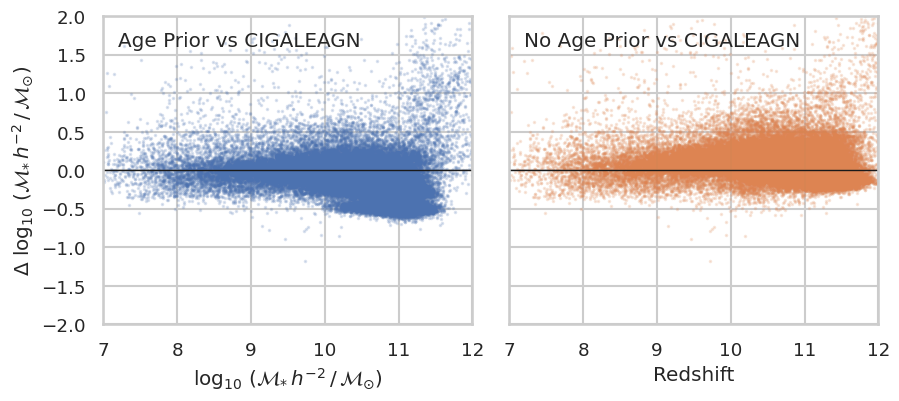

In [127]:
print('fast1 minus cigaleagn = {:.3f} +/- {:.3f} ({:.3f})'.format(
    np.mean(fast1['LOGMSTAR']-cat['LOGMSTAR_CIGALEAGN']),
    np.std(fast1['LOGMSTAR']-cat['LOGMSTAR_CIGALEAGN']),
    np.median(fast1['LOGMSTAR']-cat['LOGMSTAR_CIGALEAGN'])))    
print('fast2 minus cigale = {:.3f} +/- {:.3f} ({:.3f})'.format(
    np.mean(fast2['LOGMSTAR']-cat['LOGMSTAR_CIGALEAGN']),
    np.std(fast2['LOGMSTAR']-cat['LOGMSTAR_CIGALEAGN']),
    np.median(fast2['LOGMSTAR']-cat['LOGMSTAR_CIGALEAGN'])))    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
ax1.scatter(fast1['LOGMSTAR'], fast1['LOGMSTAR']-cat['LOGMSTAR_CIGALEAGN'], s=1, alpha=0.2, color=colors[0])
ax2.scatter(fast2['LOGMSTAR'], fast2['LOGMSTAR']-cat['LOGMSTAR_CIGALEAGN'], s=1, alpha=0.2, color=colors[1])
for xx, label in zip((ax1, ax2), ('Age Prior vs CIGALEAGN', 'No Age Prior vs CIGALEAGN')):
    xx.set_ylim(-2, 2)
    xx.text(0.04, 0.95, label, ha='left', va='top', 
            transform=xx.transAxes)#, fontsize=10)
    xx.axhline(y=0, color='k', lw=1)
ax1.set_xlim(7, 12)
ax2.set_xlim(7, 12)
ax1.set_xlabel(r'$\log_{10}\, (\mathcal{M}_{*}\, h^{-2}\, /\, \mathcal{M}_{\odot})$');
ax2.set_xlabel('Redshift')
ax1.set_ylabel(r'$\Delta\ \log_{10}\, (\mathcal{M}_{*}\, h^{-2}\, /\, \mathcal{M}_{\odot})$');
fig.subplots_adjust(wspace=0.1)

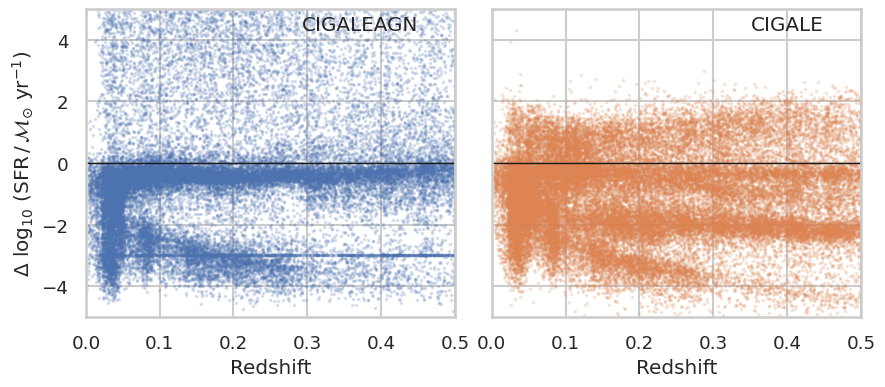

In [152]:
logsfr = fast2['SFR']
logsfr[logsfr == 0] = 1e-3
logsfr = np.log10(logsfr)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
ax1.scatter(fast1['Z'], logsfr-cat['LOGSFR_CIGALEAGN'], s=1, alpha=0.2, color=colors[0])
ax2.scatter(fast2['Z'], logsfr-np.log10(cat['SFR_CIGALE']), s=1, alpha=0.2, color=colors[1])
for xx, label in zip((ax1, ax2), ('CIGALEAGN', 'CIGALE')):
    xx.set_ylim(-5, 5)
    xx.set_xlim(0, 0.5)
    xx.set_xlabel('Redshift')
    xx.text(0.9, 0.95, label, ha='right', va='center', 
            transform=xx.transAxes)#, fontsize=10)
    xx.axhline(y=0, color='k', lw=1)
ax1.set_ylabel(r'$\Delta\ \log_{10}\, (\mathrm{SFR}\, /\, \mathcal{M}_{\odot}\ \mathrm{yr}^{-1})$');
fig.subplots_adjust(wspace=0.1)